# Игры — Формирование модели монетизации

<div style="border:solid black 2px; padding: 20px">

**Задача:** Cформировать модель монетизации игрового приложения.

**Описание:**
Многие игры зарабатывают с помощью рекламы. И все они сталкиваются с противоречием; Пользователь разозлится и уйдёт, если начать показывать ему рекламу раньше, чем игра его затянет. Но чем позже создатели игры включат рекламу, тем меньше они заработают. Аналитик должен помочь бизнесу выбрать оптимальное время для запуска рекламы. Зная расходы на продвижение игры, надо рассчитать её окупаемость при разных сценариях. 

**Ход исследования:**


1. Предобработка данных:

- Загрузка данных.
- Изучение структуры данных.
- Исследование пропущенных значений.
- Приведение типов данных к соответствующим.
- Обработка дубликатов.
- Проверка корректности наименований столбцов и значений.

2. Исследовательский анализ данных:

- Анализ распредления регистрируемых событий по времени.
- Анализ прохождения уровня пользователями.
- Распределение строительства зданий по времени.
- Анализ рекламных источников привлечения.
- Вычисление "лайфтайма" игроков и их кластеризация по времени прохождения уровня

3. Проверка статистических гипотез:

a) **Нулевая гипотеза (H0):** Среднее время прохождения уровня для группы игроков, завершивших первый уровень через победу над врагом и проект, равно.

**Альтернативная гипотеза (H1):** Среднее время прохождения уровня для группы игроков, завершивших первый уровень через победу над врагом и проект, не равно.

б) **Нулевая гипотеза (H0):** Распределение игроков, начинающих игру в определенный день недели, не влияет на их шансы успешно завершить первый уровень.

**Альтернативная гипотеза (H1):** Игроки, начинающие игру в определенный день недели, имеют больше (или меньше) шансов успешно завершить первый уровень.

4. Формирование рекомендаций по улучшении модели монетизации игрового приложения.

**Описание датасетов:**
Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики. Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки. В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты
пользователей, которые начали пользоваться приложением в период с 4 по 10 мая
включительно.

**Датасет game_actions.csv:**
1. event_datetime — время события;
2. event — одно из трёх событий:
- building — объект построен,
- finished_stage_1 — первый уровень завершён,
- project — проект завершён;
3. building_type — один из трёх типов здания:
- assembly_shop — сборочный цех,
- spaceport — космопорт,
- research_center — исследовательский центр;
4. user_id — идентификатор пользователя;
5. project_type — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

**Датасет ad_costs.csv** содержит колонки:
1. day - день, в который был совершен клик по объявлению
2. source - источник трафика
3. cost - стоимость кликов

**Датасет user_source.csv** содержит колонки:
1. user_id - идентификатор пользователя
2. source - источников, с которого пришёл пользователь, установивший приложение

По итогам исследования подготовьте презентацию. Для создания презентации используйте любой удобный инструмент, но отправить презентацию нужно обязательно в формате pdf, прикрепив ссылку на файл в основном проекте.

## Предобработка данных

### Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from itertools import combinations

game_actions = pd.read_csv('https://code.s3.yandex.net/datasets/game_actions.csv')
ad_costs = pd.read_csv('https://code.s3.yandex.net/datasets/ad_costs.csv')
user_source = pd.read_csv('https://code.s3.yandex.net/datasets/user_source.csv')

### Изучение структуры данных

In [2]:
print(game_actions.info())
print(ad_costs.info())
print(user_source.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 

**Датасет game_actions:**

- **event_datetime:** Сейчас данное поле имеет тип object и следует привести его к типу datetime для дальнейшего удобства анализа и работы с данными.
- **building_type:** Есть пропущенные значения. Пустые значения в типе постройки связаны с произошедшими событиями: finished_stage_1 или project. Логично оставить незаполненные значения.
- **project_type:** Это поле также содержит много пропущенных значений. Это связано с тем, что не все пользователи завершили проект при фиксации определенного события.

**Датасет ad_costs:**

Все поля в этом датасете кажутся нормальными.

**Датасет user_source:**

Нет пропущенных значений в данном датасете.

### Исследование пропущенных значений.

In [3]:
print(game_actions.isnull().sum())
print(ad_costs.isnull().sum())
print(user_source.isnull().sum())

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64
source    0
day       0
cost      0
dtype: int64
user_id    0
source     0
dtype: int64


In [4]:
nan_building_rows = game_actions[game_actions['building_type'].isna()]
print(f'Тип постройки не указан в событиях:',nan_building_rows['event'].unique())

count_finished_stage_1 = len(game_actions[game_actions['event'] == 'finished_stage_1'])
count_project = len(game_actions[game_actions['event'] == 'project'])

print("Количество строк с событием 'finished_stage_1':", count_finished_stage_1)
print("Количество строк с событием 'project':", count_project)

Тип постройки не указан в событиях: ['finished_stage_1' 'project']
Количество строк с событием 'finished_stage_1': 5817
Количество строк с событием 'project': 1866


**Вывод**: Тип постройки не указывается при завершении первого уровня/проекта.

In [5]:
nan_project_rows = game_actions[game_actions['project_type'].isna()]
print(f'Тип проекта не указан в событиях:',nan_project_rows['event'].unique())

# Можно заменить пустые значения на "нет проекта"
game_actions['project_type'].fillna('no_project', inplace=True)

Тип проекта не указан в событиях: ['building' 'finished_stage_1']


**Вывод**: Тип проекта не указывается при постройки здания/завершении первого уровня.

### Приведение типов данных к соответствующим.

In [6]:
# Приведение event_datetime к типу datetime
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
print(game_actions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135640 non-null  datetime64[ns]
 1   event           135640 non-null  object        
 2   building_type   127957 non-null  object        
 3   user_id         135640 non-null  object        
 4   project_type    135640 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB
None


### Обработка дубликатов.

In [7]:
print("Количество явных дубликатов в датасете game_actions:", game_actions.duplicated().sum())
print("Количество явных дубликатов в датасете ad_costs:", ad_costs.duplicated().sum())
print("Количество явных дубликатов в датасете user_source:", user_source.duplicated().sum())

Количество явных дубликатов в датасете game_actions: 1
Количество явных дубликатов в датасете ad_costs: 0
Количество явных дубликатов в датасете user_source: 0


**Вывод**: Обнаружен один явный дубликат в game_actions

In [8]:
game_actions.drop_duplicates(inplace=True)
print("Количество явных дубликатов в датасете game_actions:", game_actions.duplicated().sum())

Количество явных дубликатов в датасете game_actions: 0


#### Дубликаты по столбцам 'event', 'building_type', 'user_id'

In [9]:
duplicate_rows = game_actions[game_actions.duplicated(subset=['event', 'building_type', 'user_id'])]
print("Количество дубликатов:", len(duplicate_rows))
print("Уникальные значения в столбце 'event' для дубликатов:", duplicate_rows['event'].unique())

Количество дубликатов: 93478
Уникальные значения в столбце 'event' для дубликатов: ['building']


**Вывод**: Наличие таких дубликатов можно связать с наличием возможности у пользователя строить здания одного и того же типа несколько раз.

### Проверка корректности наименований столбцов и значений.

In [10]:
print("Датасет game_actions:")
print(game_actions.columns)
for col in game_actions.columns:
    unique_values = game_actions[col].unique()
    print(f"Уникальные значения в столбце '{col}': {unique_values}")

print("\nДатасет ad_costs:")
print(ad_costs.columns)
for col in ad_costs.columns:
    unique_values = ad_costs[col].unique()
    print(f"Уникальные значения в столбце '{col}': {unique_values}")

print("\nДатасет user_source:")
print(user_source.columns)
for col in user_source.columns:
    unique_values = user_source[col].unique()
    print(f"Уникальные значения в столбце '{col}': {unique_values}")


Датасет game_actions:
Index(['event_datetime', 'event', 'building_type', 'user_id', 'project_type'], dtype='object')
Уникальные значения в столбце 'event_datetime': ['2020-05-04T00:00:01.000000000' '2020-05-04T00:00:03.000000000'
 '2020-05-04T00:00:16.000000000' ... '2020-06-05T08:57:52.000000000'
 '2020-06-05T12:12:27.000000000' '2020-06-05T12:32:49.000000000']
Уникальные значения в столбце 'event': ['building' 'finished_stage_1' 'project']
Уникальные значения в столбце 'building_type': ['assembly_shop' 'spaceport' nan 'research_center']
Уникальные значения в столбце 'user_id': ['55e92310-cb8e-4754-b622-597e124b03de'
 'c07b1c10-f477-44dc-81dc-ec82254b1347'
 '6edd42cc-e753-4ff6-a947-2107cd560710' ...
 '7b225969-375a-455e-a14a-ed1ab373fb65'
 'cafd1b8b-507b-49ae-abf0-89fe863a8b03'
 'bdc53e19-462a-4dc3-8b55-b4a34278af6a']
Уникальные значения в столбце 'project_type': ['no_project' 'satellite_orbital_assembly']

Датасет ad_costs:
Index(['source', 'day', 'cost'], dtype='object')
Уникальные 

**Вывод**: Все наименования столбцов и значения корректны

## Исследовательский анализ данных:

<a id="section_1"></a>
### Распредление регистрируемых событий по времени

In [11]:
# Извлечение даты из datetime
game_actions['event_date'] = game_actions['event_datetime'].dt.date

events_by_date = game_actions.groupby(['event_date', 'event']).size().reset_index(name='count')

pivot_events_by_date = events_by_date.pivot(index='event_date', columns='event', values='count').reset_index()
pivot_events_by_date.fillna(0, inplace=True)

print(pivot_events_by_date)

event  event_date  building  finished_stage_1  project
0      2020-05-04    8170.0               1.0      0.0
1      2020-05-05    9052.0               3.0      0.0
2      2020-05-06    9921.0               4.0      0.0
3      2020-05-07   10847.0              11.0      0.0
4      2020-05-08   12030.0              28.0      1.0
5      2020-05-09   13066.0              60.0      3.0
6      2020-05-10   15022.0             151.0     34.0
7      2020-05-11    7876.0             233.0     76.0
8      2020-05-12    7509.0             313.0     96.0
9      2020-05-13    7060.0             389.0    175.0
10     2020-05-14    6140.0             516.0    174.0
11     2020-05-15    5155.0             560.0    237.0
12     2020-05-16    4243.0             649.0    207.0
13     2020-05-17    3180.0             587.0    188.0
14     2020-05-18    2236.0             473.0    138.0
15     2020-05-19    1787.0             397.0    135.0
16     2020-05-20    1349.0             379.0    109.0
17     202

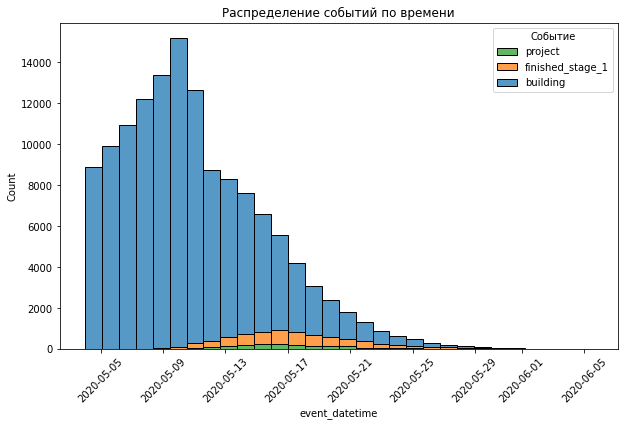

In [12]:
# Анализ распределения ключевых показателей
plt.figure(figsize=(10, 6))
sns.histplot(data=game_actions, x='event_datetime', bins=30, hue='event', multiple='stack')
plt.title('Распределение событий по времени')
plt.xticks(rotation=45)
plt.legend(title='Событие', labels=['project', 'finished_stage_1', 'building'])
plt.show()

**Вывод:** Данные отражают активность игроков, начавших играть в период с 4 по 10 мая. Большинство пользователей было наиболее активным в середине мая: пик строительства приходится на 10 мая, завершение первого уровня — на 16 мая, и реализация проектов достигла максимума 15 мая. После этого активность резко снижается. Это указывает на возможное угасание интереса к игре после первой недели использования.

### Анализ прохождения уровня пользователями

In [13]:
# Всего уникальных игроков
total_users = game_actions['user_id'].unique()

# Уникальные игроки для каждого события: победа над игроком / завершение проекта 
victory_users = game_actions[game_actions['event'] == 'finished_stage_1']['user_id'].unique()
project_users = game_actions[game_actions['event'] == 'project']['user_id'].unique()

# Игроки, которые не завершили первый уровень
not_finished_users = game_actions[~game_actions['user_id'].isin(np.concatenate([victory_users, project_users]))]['user_id'].unique()

print(f'Всего уникальных игроков:', len(total_users))
print(f'Количество игроков, завершивших первый уровень путем победы над врагом:', len(victory_users))
print(f'Количество игроков, завершивших первый уровень путем реализации проекта:', len(project_users))
print(f'Количество игроков, не завершивших первый уровень:', len(not_finished_users))

Всего уникальных игроков: 13576
Количество игроков, завершивших первый уровень путем победы над врагом: 5817
Количество игроков, завершивших первый уровень путем реализации проекта: 1866
Количество игроков, не завершивших первый уровень: 7759


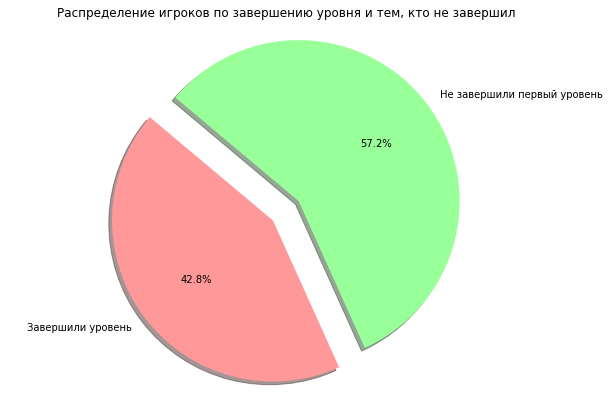

In [14]:
labels = ['Завершили уровень', 'Не завершили первый уровень']
sizes = [len(victory_users), len(not_finished_users)]
colors = ['#ff9999', '#99ff99']
explode = (0.1, 0.1) 

plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal') 
plt.title('Распределение игроков по завершению уровня и тем, кто не завершил')
plt.show()

In [15]:
# Пересечение пользователей между победой над врагом и реализацией проекта
intersection_victory_project = np.intersect1d(victory_users, project_users)
print(f"Количество пользователей, которые завершили уровень и победой, и реализацией проекта: {len(intersection_victory_project)}")

# Пересечение пользователей между не завершившими и победившими врага
intersection_not_finished_victory = np.intersect1d(not_finished_users, victory_users)
print(f"Количество пользователей, которые не завершили уровень, но победили врага: {len(intersection_not_finished_victory)}")

# Пересечение пользователей между не завершившими и реализовавшими проекти
intersection_not_finished_project = np.intersect1d(not_finished_users, project_users)
print(f"Количество пользователей, которые не завершили уровень, но реализовали проект: {len(intersection_not_finished_project)}")

Количество пользователей, которые завершили уровень и победой, и реализацией проекта: 1866
Количество пользователей, которые не завершили уровень, но победили врага: 0
Количество пользователей, которые не завершили уровень, но реализовали проект: 0


**Вывод:** 1866 пользователей завершили уровень и победой над врагом, и реализацией проекта, что указывает на двойственность в данных. Остальные игроки между группами не пересекаются. 

In [16]:
game_actions_sorted = game_actions.sort_values(by='event_datetime')

start_time = game_actions_sorted.groupby('user_id')['event_datetime'].first()

# Определяем время завершения для каждого пользователя
end_time_stage = game_actions_sorted[(game_actions_sorted['event'] == 'finished_stage_1') | (game_actions_sorted['event'] == 'project')].groupby('user_id')['event_datetime'].first()

# Вычисление времени, проведенного игроками до завершения первого уровня
time_spent = (end_time_stage - start_time).dt.total_seconds()

# Переводим секунды в дни
time_spent_days = time_spent / (3600 * 24)

print("Среднее время, проведенное игроками до завершения первого уровня:", round(time_spent_days.mean(), 2), "дней")
print("Медианное время, проведенное игроками до завершения первого уровня:", round(time_spent_days.median(), 2), "дней")

Среднее время, проведенное игроками до завершения первого уровня: 11.36 дней
Медианное время, проведенное игроками до завершения первого уровня: 10.99 дней


**Вывод:** Примерно 11 дней уходит среднестатистическому игроку на прохождение первого уровня игры.

### Распределение строительства зданий по времени

Количество построек разных типов:
spaceport          59325
assembly_shop      54494
research_center    14137
Name: building_type, dtype: int64


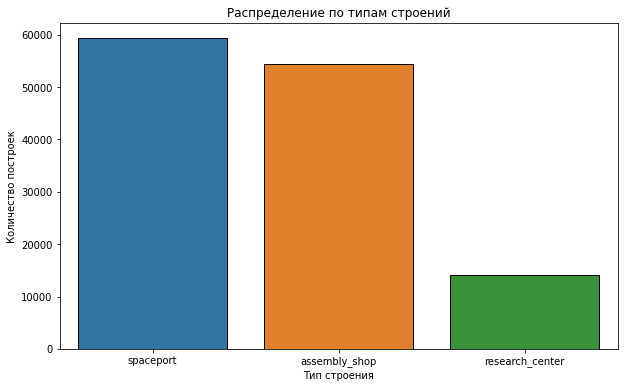

In [17]:
buildings = game_actions['building_type'].value_counts()

print("Количество построек разных типов:")
print(buildings)

plt.figure(figsize=(10,6))
sns.barplot(x=buildings.index, y=buildings.values, edgecolor='black')
plt.title("Распределение по типам строений")
plt.ylabel("Количество построек")
plt.xlabel("Тип строения")
plt.show()

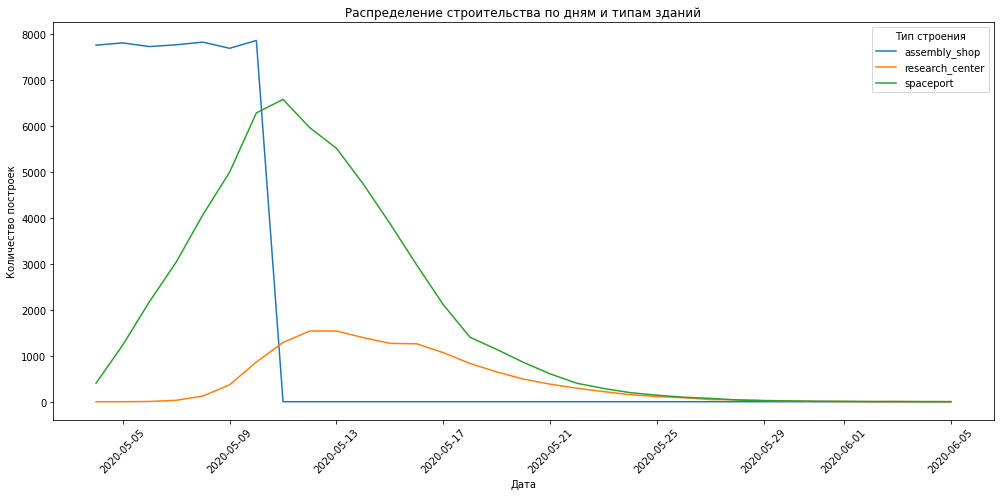

In [18]:
# Группировка данных по дате и типу здания
buildings_by_date = game_actions.groupby(['event_date', 'building_type']).size().reset_index(name='count')

pivot_buildings_by_date = buildings_by_date.pivot(index='event_date', columns='building_type', values='count').reset_index()
pivot_buildings_by_date.fillna(0, inplace=True)

# Визуализация
plt.figure(figsize=(14,7))
for column in pivot_buildings_by_date.columns[1:]:
    plt.plot(pivot_buildings_by_date['event_date'], pivot_buildings_by_date[column], label=column)

plt.title("Распределение строительства по дням и типам зданий")
plt.ylabel("Количество построек")
plt.xlabel("Дата")
plt.legend(title="Тип строения")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Вывод:** В первые дни после регистрации, начиная с 4 мая, игроки активно строили объекты типа "assembly_shop". Это может быть связано с начальной стадией игры, где строительство таких объектов является обязательным. Однако начиная с 11 мая, строительство этого объекта полностью прекратилось. Вероятно, игроки перешли к следующим этапам уровня, где требовалось строительство более продвинутых объектов.

В этот же период наблюдается рост количества строительства объектов "spaceport" и "research_center". Это указывает на то, что игроки, продвигаясь уровню, начинают строить более сложные объекты. По распредлению можно видеть, что для прохождения уровня игры требовалось наличие постройки "spaceport". Объект "research_center", возможно, является "финальным" и наиболее ключевым для перехода на следующий уровень.

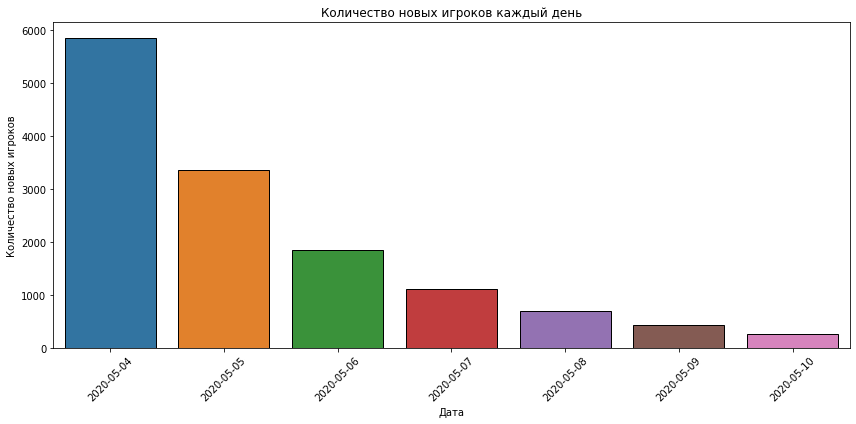

In [19]:
first_launch = game_actions.groupby('user_id')['event_datetime'].min().reset_index()

first_launch['date'] = first_launch['event_datetime'].dt.date
first_launch = first_launch.sort_values('date')

plt.figure(figsize=(12, 6))
sns.countplot(data=first_launch, x='date', edgecolor='black')
plt.title('Количество новых игроков каждый день')
plt.xlabel('Дата')
plt.ylabel('Количество новых игроков')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#### Стратегии строительства зданий игроками, прошедшими уровень

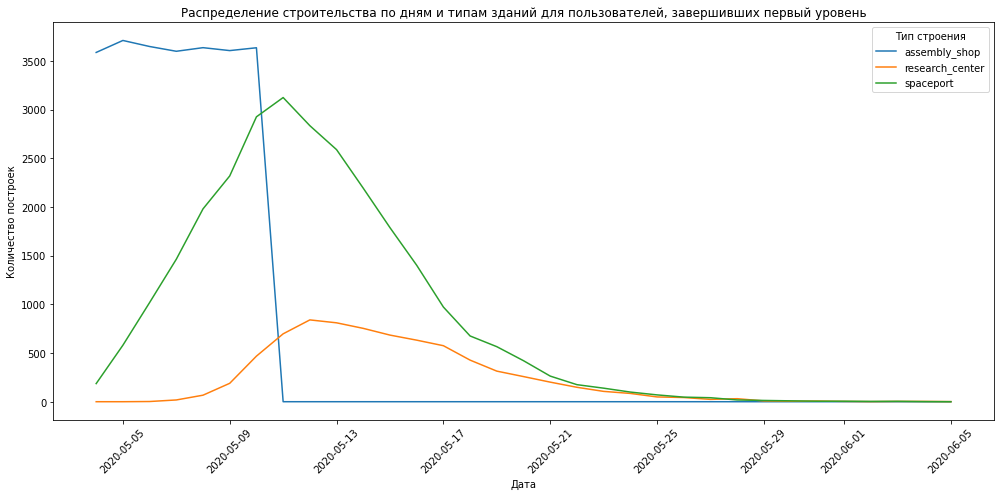

In [20]:
# Фильтруем данные для пользователей, которые завершили первый уровень
finished_users_data = game_actions[game_actions['user_id'].isin(np.concatenate([victory_users, project_users]))]

# Группировка данных по дате и типу здания для завершивших первый уровень
buildings_by_date_finished = finished_users_data.groupby(['event_date', 'building_type']).size().reset_index(name='count')

pivot_buildings_by_date_finished = buildings_by_date_finished.pivot(index='event_date', columns='building_type', values='count').reset_index()
pivot_buildings_by_date_finished.fillna(0, inplace=True)

# Визуализация
plt.figure(figsize=(14,7))
for column in pivot_buildings_by_date_finished.columns[1:]:
    plt.plot(pivot_buildings_by_date_finished['event_date'], pivot_buildings_by_date_finished[column], label=column)

plt.title("Распределение строительства по дням и типам зданий для пользователей, завершивших первый уровень")
plt.ylabel("Количество построек")
plt.xlabel("Дата")
plt.legend(title="Тип строения")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Стратегии строительства зданий игроками, не прошедшими уровень

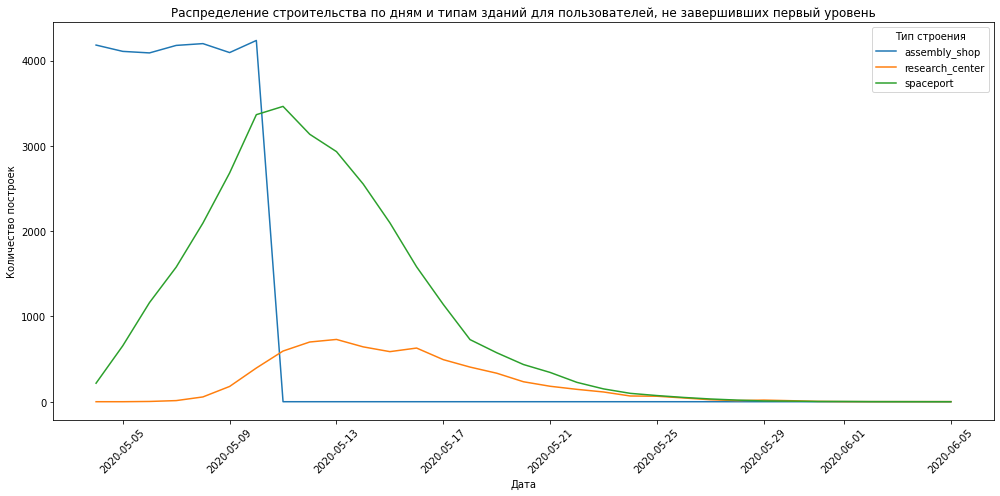

In [21]:
# Фильтруем данные для пользователей, которые не завершили первый уровень
not_finished_users_data = game_actions[game_actions['user_id'].isin(not_finished_users)]

# Группировка данных по дате и типу здания для не завершивших первый уровень
buildings_by_date_not_finished = not_finished_users_data.groupby(['event_date', 'building_type']).size().reset_index(name='count')
pivot_buildings_by_date_not_finished = buildings_by_date_not_finished.pivot(index='event_date', columns='building_type', values='count').reset_index()
pivot_buildings_by_date_not_finished.fillna(0, inplace=True)

# Визуализация
plt.figure(figsize=(14,7))
for column in pivot_buildings_by_date_not_finished.columns[1:]:
    plt.plot(pivot_buildings_by_date_not_finished['event_date'], pivot_buildings_by_date_not_finished[column], label=column)

plt.title("Распределение строительства по дням и типам зданий для пользователей, не завершивших первый уровень")
plt.ylabel("Количество построек")
plt.xlabel("Дата")
plt.legend(title="Тип строения")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Вывод:** Стратегии игроков обеих групп по строительству зданий не отличаются, что подтверждает последовательность строительства: 
1. assembly_shop — сборочный цех,
2. spaceport — космопорт,
3. research_center — исследовательский центр;

In [22]:
# Определяем время постройки космопорта для каждого пользователя
end_time_spaceport = game_actions_sorted[game_actions_sorted['building_type'] == 'spaceport'].groupby('user_id')['event_datetime'].first()

# Определяем время постройки исследовательского центра для каждого пользователя
end_time_research_center = game_actions_sorted[game_actions_sorted['building_type'] == 'research_center'].groupby('user_id')['event_datetime'].first()

# Вычисляем время, проведенное игроками до постройки космопорта
time_spent_spaceport = (end_time_spaceport - start_time).dt.total_seconds() / 3600 / 24

# Вычисляем время, проведенное игроками до постройки исследовательского центра
time_spent_research_center = (end_time_research_center - start_time).dt.total_seconds() / 3600 / 24

print("Среднее время, проведенное игроками до постройки космопорта:", round(time_spent_spaceport.mean(), 2), "дней")
print("Медианное время, проведенное игроками до постройки космопорта:", round(time_spent_spaceport.median(), 2), "дней")
print("Среднее время, проведенное игроками до постройки исследовательского центра:", round(time_spent_research_center.mean(), 2), "дней")
print("Медианное время, проведенное игроками до постройки исследовательского центра:", round(time_spent_research_center.median(), 2), "дней")

Среднее время, проведенное игроками до постройки космопорта: 3.45 дней
Медианное время, проведенное игроками до постройки космопорта: 3.09 дней
Среднее время, проведенное игроками до постройки исследовательского центра: 9.28 дней
Медианное время, проведенное игроками до постройки исследовательского центра: 8.61 дней


#### На строительстве какого здания происходит "отвал" игроков

In [23]:
# Фильтруем данные только для пользователей, которые не завершили первый уровень
not_finished_users_data = game_actions[game_actions['user_id'].isin(not_finished_users)]

# Группируем данные по user_id и находим дату последнего события для каждого пользователя
last_event_dates = not_finished_users_data.groupby('user_id').agg({'event_datetime': 'max'})

# Объединяем и подсчитываем количество пользователей для каждого последнего события
merged_data = last_event_dates.merge(not_finished_users_data, on=['user_id', 'event_datetime'])

dropoff_counts = merged_data['event'].value_counts()
dropoff_building_counts = merged_data['building_type'].value_counts()

print(dropoff_counts)
print(dropoff_building_counts)

building    7759
Name: event, dtype: int64
spaceport          5004
research_center    2136
assembly_shop       619
Name: building_type, dtype: int64


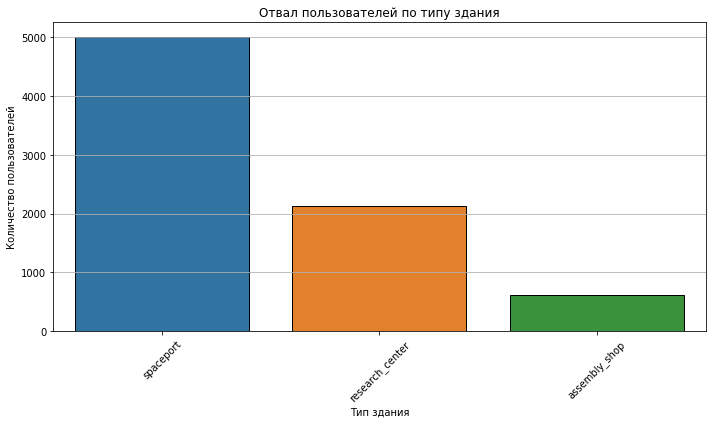

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x=dropoff_building_counts.index, y=dropoff_building_counts.values, edgecolor='black')
plt.title('Отвал пользователей по типу здания')
plt.ylabel('Количество пользователей')
plt.xlabel('Тип здания')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Вывод:** Большинство пользователей, которые не завершили первый уровень, отвалились после постройки здания: из них 5004 пользователей построили "spaceport", 2136 — "research_center", и только 619 — "assembly_shop". Это говорит о том, что многие пользователи продолжают играть и строить более сложные здания, но по каким-то причинам останавливаются на строительстве "промежуточной" для завершения уровня постройки - "spaceport".

### Анализ рекламных источников привлечения

In [25]:
# Группируем данные по рекламным источникам
total_costs = ad_costs.groupby('source')['cost'].sum().reset_index()
users_per_source = user_source.groupby('source')['user_id'].count().reset_index()

merged_data = pd.merge(total_costs, users_per_source, on='source')
merged_data['cost_per_user'] = merged_data['cost'] / merged_data['user_id']
merged_data = merged_data.sort_values(by='cost_per_user')

print(merged_data)

                    source         cost  user_id  cost_per_user
3  youtube_channel_reklama  1068.119204     2686       0.397662
2            yandex_direct  2233.111449     4817       0.463590
1    instagram_new_adverts  2161.441691     3347       0.645785
0             facebook_ads  2140.904643     2726       0.785365


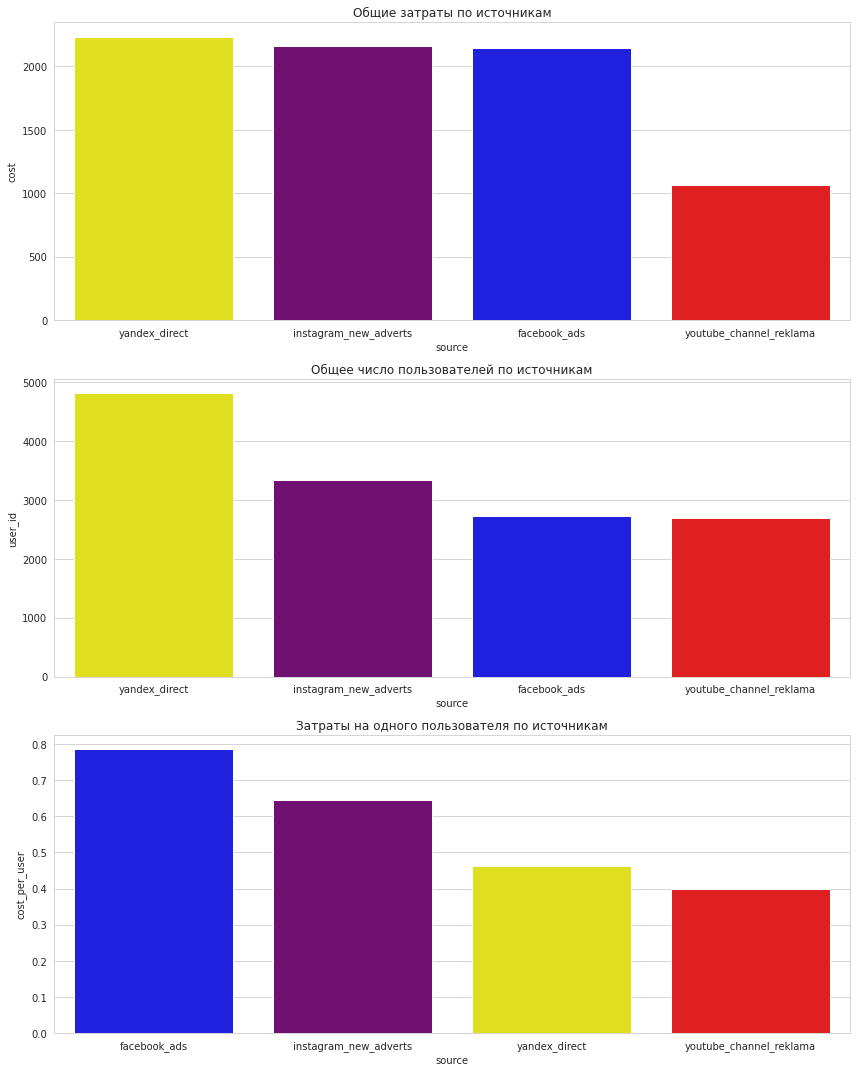

In [26]:
sns.set_style("whitegrid")

color_dict = {
    'youtube_channel_reklama': 'red',
    'yandex_direct': 'yellow',
    'instagram_new_adverts': 'purple',
    'facebook_ads': 'blue'
}

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

sns.barplot(data=merged_data.sort_values(by='cost', ascending=False), x='source', y='cost', ax=axes[0], palette=color_dict).set_title('Общие затраты по источникам')
sns.barplot(data=merged_data.sort_values(by='user_id', ascending=False), x='source', y='user_id', ax=axes[1], palette=color_dict).set_title('Общее число пользователей по источникам')
sns.barplot(data=merged_data.sort_values(by='cost_per_user', ascending=False), x='source', y='cost_per_user', ax=axes[2], palette=color_dict).set_title('Затраты на одного пользователя по источникам')

plt.tight_layout()
plt.show()

**Вывод:** Yandex Direct выделяется как наиболее ценный источник, привлекая наибольшее количество пользователей при относительно невысокой стоимости на одного пользователя. В то время как YouTube Channel Reklama демонстрирует наивысшую экономическую эффективность, обеспечивая самую низкую стоимость привлечения одного пользователя. Facebook Ads требует дополнительного внимания и анализа, так как он имеет наивысшую стоимость привлечения при наименьшем количестве привлеченных пользователей.

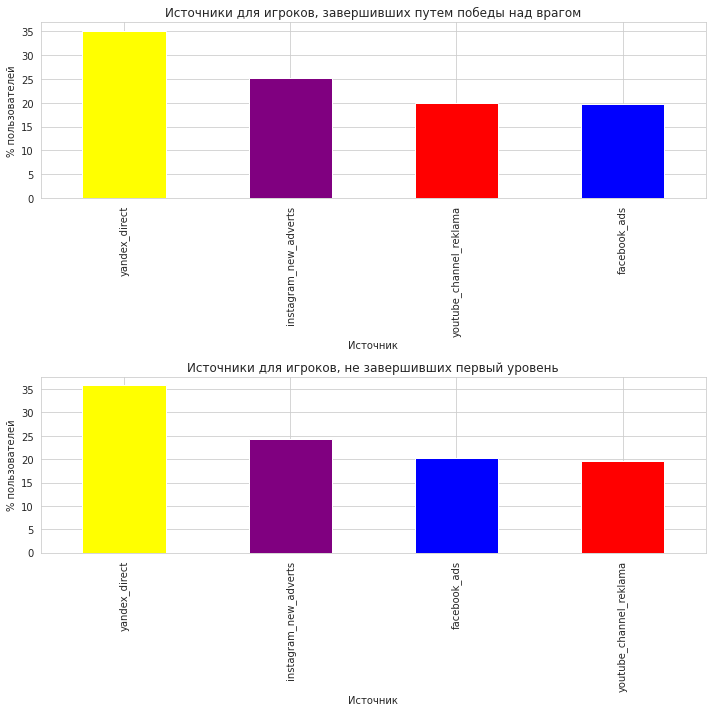

In [27]:
# Создаем функцию
def source_distribution(users_segment):
    return user_source[user_source['user_id'].isin(users_segment)]['source'].value_counts(normalize=True) * 100

victory_source_dist = source_distribution(victory_users)
not_finished_source_dist = source_distribution(not_finished_users)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

victory_source_dist.plot(kind='bar', ax=axs[0], color=[color_dict[source] for source in victory_source_dist.index], title='Источники для игроков, завершивших путем победы над врагом')
not_finished_source_dist.plot(kind='bar', ax=axs[1], color=[color_dict[source] for source in not_finished_source_dist.index], title='Источники для игроков, не завершивших первый уровень')

for ax in axs:
    ax.set_ylabel('% пользователей')
    ax.set_xlabel('Источник')

plt.tight_layout()
plt.show()

**Вывод:** Yandex Direct является самым популярным источником привлечения игроков для обеих категорий пользователей. Instagram New Adverts следует за ним, имея чуть большую долю среди игроков, завершивших уровень путем победы. Facebook Ads и YouTube Channel Reklama меняются местами в зависимости от категории игроков, но их доли в целом схожи. 

### Вычисление "лайфтайма" игроков

In [28]:
full_data = pd.merge(game_actions, user_source, on='user_id')

# Находим дату первого события для каждого пользователя
first_event_date = full_data.groupby('user_id')['event_datetime'].min().reset_index()
first_event_date.columns = ['user_id', 'first_event_datetime']

# Добавляем информацию о дате первого события в новый датасет
full_data = pd.merge(full_data, first_event_date, on='user_id')

full_data['days_since_first_event'] = (full_data['event_datetime'] - full_data['first_event_datetime']).dt.days

# Вычисляем дату последнего события для каждого пользователя
last_event_date = full_data.groupby('user_id')['event_datetime'].max().reset_index()
last_event_date.columns = ['user_id', 'last_event_datetime']

full_data = pd.merge(full_data, last_event_date, on='user_id')

In [29]:
user_lifetime_data = full_data.groupby(['user_id', 'source']).agg({
    'first_event_datetime': 'min',
    'last_event_datetime': 'max'
}).reset_index()

user_lifetime_data['user_lifetime'] = (user_lifetime_data['last_event_datetime'] - user_lifetime_data['first_event_datetime']).dt.days

overall_avg_lifetime = user_lifetime_data['user_lifetime'].mean()
avg_lifetime_by_source = user_lifetime_data.groupby('source')['user_lifetime'].mean().reset_index()

print(f"Общая средняя продолжительность жизни пользователя: {overall_avg_lifetime:.2f} дней")
print("Средняя продолжительность жизни по источникам:")
print(avg_lifetime_by_source)

Общая средняя продолжительность жизни пользователя: 10.18 дней
Средняя продолжительность жизни по источникам:
                    source  user_lifetime
0             facebook_ads      10.223404
1    instagram_new_adverts      10.289812
2            yandex_direct      10.121652
3  youtube_channel_reklama      10.080045


### Кластеризация пользователей

In [30]:
# Фильтруем только тех пользователей, которые смогли пройти уровень
filtered_data = full_data[full_data['user_id'].isin(np.concatenate([victory_users, project_users]))].copy()

# Рассчитываем время прохождения
filtered_data.loc[:, 'completion_time'] = (filtered_data['last_event_datetime'] - filtered_data['first_event_datetime']).dt.total_seconds()
completion_times = filtered_data.groupby('user_id')['completion_time'].max().reset_index()

scaler = StandardScaler()
completion_times_scaled = scaler.fit_transform(completion_times[['completion_time']])

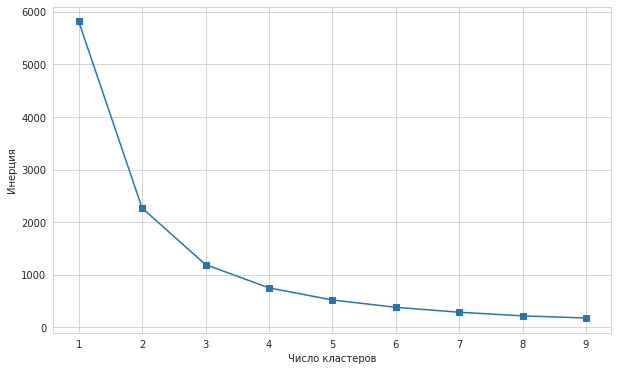

In [31]:
# Определяем оптимальное количество кластеров
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(completion_times_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='s')
plt.xlabel('Число кластеров')
plt.ylabel('Инерция')
plt.show()

**Вывод:** Уменьшение инерции становится менее выраженным после 3 кластеров. Поэтому будем использовать 3 кластера.

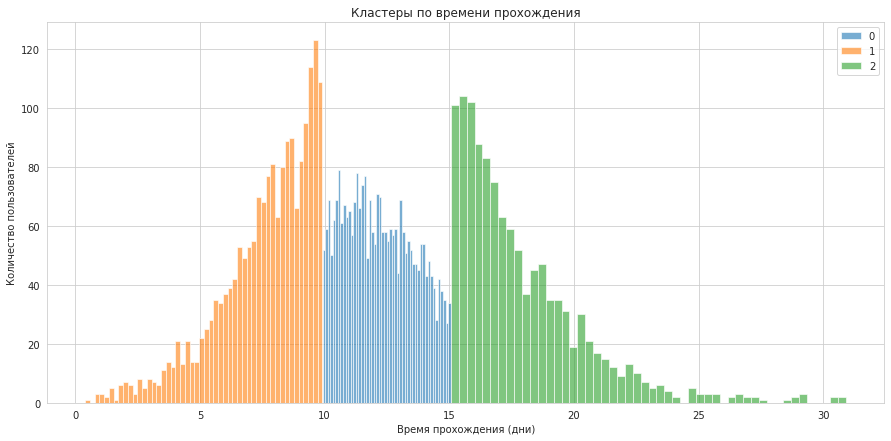

In [32]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(completion_times_scaled)
completion_times['cluster'] = kmeans.labels_
completion_times['completion_time_days'] = completion_times['completion_time'] / 86400

plt.figure(figsize=(15, 7))
completion_times.groupby('cluster')['completion_time_days'].hist(alpha=0.6, bins=50, legend=True)
plt.xlabel('Время прохождения (дни)')
plt.ylabel('Количество пользователей')
plt.title('Кластеры по времени прохождения')
plt.show()

In [33]:
cluster_ranges = completion_times.groupby('cluster')['completion_time_days'].agg(['min', 'max']).reset_index()
cluster_ranges['range'] = cluster_ranges.apply(lambda row: f"{row['min']:.2f} - {row['max']:.2f} дней", axis=1)

print(cluster_ranges[['cluster', 'range']])

cluster_sizes = completion_times['cluster'].value_counts().reset_index()
cluster_sizes.columns = ['cluster', 'size']

print('\n', cluster_sizes)

   cluster               range
0        0   9.92 - 15.06 дней
1        1    0.40 - 9.91 дней
2        2  15.06 - 30.92 дней

    cluster  size
0        0  2786
1        1  1870
2        2  1161


**Вывод:**
- **Кластер 1** – это группа из 1870 пользователей, которые завершают уровень в пределах 0.40-9.91 дней. Этот кластер представляет собой игроков, проходящих уровень относительно быстро.

- **Кластер 0** – самый большой кластер, включающий 2786 пользователей. Эти игроки завершают уровень за 9.92-15.06 дней, что можно считать средним темпом прохождения.

- **Кластер 2** представляет собой наименьшую группу из 1161 пользователя. Эти игроки тратят на прохождение уровня наибольшее количество времени: от 15.06 до 30.92 дней.

## Проверка статистических гипотез

**Нулевая гипотеза (H0):** Среднее время прохождения уровня для группы игроков, завершивших первый уровень через победу над врагом и проект, равно.

**Альтернативная гипотеза (H1):** Среднее время прохождения уровня для группы игроков, завершивших первый уровень через победу над врагом и проект, не равно.

Для проверки гипотез будем использовать тест Манна-Уитни, который используется для сравнения двух независимых выборок по их рангам. 

In [34]:
# Разделим данные на две группы (победы над врагами и проекты)
group_project = game_actions[game_actions['event'] == 'project']
project_users = group_project['user_id'].unique()

# Исключаем пользователей, выполнивших проект, из группы победителей над врагом
group_victory = game_actions[(game_actions['event'] == 'finished_stage_1') & (~game_actions['user_id'].isin(project_users))]

# Для каждого пользователя найдем время начала игры
start_times = game_actions.groupby('user_id')['event_datetime'].min()

# Добавляем столбец продолжительности для каждой группы
group_project = group_project.copy()
group_project['duration'] = group_project['user_id'].apply(lambda user: (group_project[group_project['user_id'] == user]['event_datetime'].iloc[0] - start_times[user]).total_seconds())

group_victory = group_victory.copy()
group_victory['duration'] = group_victory['user_id'].apply(lambda user: (group_victory[group_victory['user_id'] == user]['event_datetime'].iloc[0] - start_times[user]).total_seconds())

stat, p_value = mannwhitneyu(group_victory['duration'], group_project['duration'])

print("P-value:", p_value)

if p_value < 0.05:
    print("Различие статистически значимо")
else:
    print("Различие не статистически значимо")

P-value: 2.3480301414939028e-12
Различие статистически значимо


In [35]:
mean_victory_duration = group_victory['duration'].mean()
mean_project_duration = group_project['duration'].mean()

if mean_victory_duration < mean_project_duration:
    print("Стратегия победы над врагом позволяет быстрее пройти уровень")
else:
    print("Стратегия завершения проекта позволяет быстрее пройти уровень")

Стратегия победы над врагом позволяет быстрее пройти уровень


**Вывод:** На основе проведенного теста, мы можем сделать вывод о статистически значимом различии во времени прохождения уровня между группами побед и проектов. Стратегия победы над врагом позволяет быстрее пройти уровень.

**Нулевая гипотеза (H0):** Распределение игроков, начинающих игру в определенный день недели, не влияет на их шансы успешно завершить первый уровень.

**Альтернативная гипотеза (H1):** Игроки, начинающие игру в определенный день недели, имеют больше (или меньше) шансов успешно завершить первый уровень.

In [36]:
# Определим дни недели начала игры для каждого пользователя
game_actions_sorted['weekday'] = game_actions_sorted['event_datetime'].dt.weekday
start_weekday = game_actions_sorted.groupby('user_id')['weekday'].first()

# Фильтруем игроков, которые завершили уровень
completed_users = game_actions_sorted[game_actions_sorted['event'].isin(['finished_stage_1', 'project'])]['user_id'].unique()

# Формируем таблицы завершивших и не завершивших первый уровень по дням недели
weekday_tab = pd.crosstab(start_weekday, start_weekday.index.isin(completed_users), rownames=['weekday'], colnames=['completed'])
weekday_tab.columns = ['Не завершили', 'Завершили']

In [37]:
# Поправка Бонферрони
alpha = 0.05 / 21

# Проводим попарные сравнения для каждой пары дней недели
for day1, day2 in combinations(range(7), 2):
    subtable = weekday_tab.loc[[day1, day2]]
    
    chi2_statistic, p_value = chi2_contingency(subtable)[:2]
    
    if p_value < alpha:
        print(f"Дни: {day1} и {day2}. P-value: {p_value:.4f}. Различие статистически значимо")
    else:
        print(f"Дни: {day1} и {day2}. P-value: {p_value:.4f}. Различие не статистически значимо")

Дни: 0 и 1. P-value: 0.6271. Различие не статистически значимо
Дни: 0 и 2. P-value: 0.0043. Различие не статистически значимо
Дни: 0 и 3. P-value: 0.0000. Различие статистически значимо
Дни: 0 и 4. P-value: 0.0000. Различие статистически значимо
Дни: 0 и 5. P-value: 0.0000. Различие статистически значимо
Дни: 0 и 6. P-value: 0.0000. Различие статистически значимо
Дни: 1 и 2. P-value: 0.0246. Различие не статистически значимо
Дни: 1 и 3. P-value: 0.0000. Различие статистически значимо
Дни: 1 и 4. P-value: 0.0000. Различие статистически значимо
Дни: 1 и 5. P-value: 0.0000. Различие статистически значимо
Дни: 1 и 6. P-value: 0.0000. Различие статистически значимо
Дни: 2 и 3. P-value: 0.0151. Различие не статистически значимо
Дни: 2 и 4. P-value: 0.0006. Различие статистически значимо
Дни: 2 и 5. P-value: 0.0000. Различие статистически значимо
Дни: 2 и 6. P-value: 0.0004. Различие статистически значимо
Дни: 3 и 4. P-value: 0.2170. Различие не статистически значимо
Дни: 3 и 5. P-value: 0.01

**Вывод:** Исходя из результатов попарных сравнений, можно утверждать, что вероятность завершения первого уровня игры варьируется в зависимости от дня начала игры. Существуют различия между начальными днями (Понедельник, Вторник, Среда) и более поздними днями (Четверг, Пятница, Суббота, Воскресенье) являются статистически значимыми в большинстве случаев.

## Формирование модели монетизации игрового приложения.

**1. Стратегия размещения рекламы:**

Поскольку у пользователя уходит в среднем 11 дней на прохождение первого уровня, оптимальное время для включения рекламы - после 7-8 дней игры. Это позволит избежать недовольства новых игроков и, в то же время, максимизировать прибыль от рекламы для игроков, которые уже вовлечены в процесс. Однако, кластеризация показала, что есть группы пользователей, которые завершают уровень быстрее или медленнее этого среднего значения. 

Учитывая кластеризацию пользователей по длительности прохождения уровня, рекламу следует показывать персонализированно. Это предполагает разработку модели предсказания, определяющей, в какой кластер попадет пользователь на основе его первых игровых действий. Например, для пользователей, которые быстро начинают стройку космопорта, рекламу можно показывать раньше.

**2. Оптимизация привлечения игроков:**

"Yandex Direct" и "YouTube Channel Reklama" выглядят наиболее перспективно для привлечения игроков из-за своей эффективности и низкой стоимости привлечения. Привлекать новых игроков желательно в начале недели, так как это увеличивает шансы на успешное прохождение игроком уровня.

**3. Геймплейные изменения:**

Многие пользователи прекращают игру после постройки космпорта. Возможно, стоит улучшить геймплей или предоставить дополнительные стимулы и награды после этой стадии, чтобы стимулировать дальнейшую игру.

**4.  Введение дополнительных источников монетизации:**

Учитывая, что у пользователя уходит в среднем 11 дней на прохождение первого уровня, можно рассмотреть вариант продажи игровых предметов или валюты, позволяющей ускорить процесс прохождения уровней.

**Заключение:**
Монетизация игрового приложения требует тщательного балансирования между удержанием игроков и максимизацией дохода. На основе вышеуказанных результатов и рекомендаций можно разработать эффективную стратегию монетизации, которая будет учитывать интересы игроков и интересы разработчиков.

## Презентация и дашборд

**Дашборд**: https://public.tableau.com/views/_16933340036120/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link
**Презентация**: https://disk.yandex.ru/i/lMsklLMAxW_0jQ